# 相关性分析

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# plt.style.use("ggplot")
plt.style.use('fivethirtyeight')  # production use

下载数据，数据源：yahoo finance

In [2]:
tickers = [
    "^GSPC",     # sp500指数
    "^IXIC",     # 纳斯达克指数
    "DX=F",      # ICE美元指数期货合约
    "GC=F",      # COMEX黄金期货合约
    "CL=F",      # WTI原油期货合约
    "BTC-USD",   # BTC现货
    "ETH-USD"    # ETH现货
]

In [3]:
data = pdr.DataReader(tickers, "yahoo", "2018-01-01")

数据预处理

In [4]:
columns = {
    "^GSPC": "SP500",
    "^IXIC": "NASDAQ",
    "DX=F": "Dollar index",
    "GC=F": "Gold",
    "CL=F": "Crude",
    "BTC-USD": "BTCUSD",
    "ETH-USD": "ETHUSD"
}
prices = (
    data.loc[:, "Adj Close"]
        .dropna()
        .rename(columns=columns)
)
prices.tail()

Symbols,SP500,NASDAQ,Dollar index,Gold,Crude,BTCUSD,ETHUSD
Date,,,,,,,
2022-06-16,3666.770020,10646.099609,103.417000,1845.699951,117.589996,20381.650391,1067.730713
2022-06-17,3674.840088,10798.349609,104.487999,1835.599976,109.559998,20471.482422,1086.519287
2022-06-21,3764.790039,11069.299805,104.210999,1834.599976,110.650002,20710.597656,1124.824585
2022-06-22,3759.889893,11053.080078,103.981003,1834.300049,106.190002,19987.029297,1051.421875
2022-06-23,3795.729980,11232.190430,104.192001,1825.699951,104.269997,21085.876953,1143.386719


## 相关系数矩阵

In [7]:
# 使用多少天的数据计算相关系数
period = 90

corr = prices.tail(period).corr()
corr

Symbols,SP500,NASDAQ,Dollar index,Gold,Crude,BTCUSD,ETHUSD
Symbols,,,,,,,
SP500,1.000000,0.982125,-0.771755,0.694716,-0.470111,0.952919,0.928743
NASDAQ,0.982125,1.000000,-0.836767,0.709614,-0.514215,0.954408,0.916153
Dollar index,-0.771755,-0.836767,1.000000,-0.641237,0.538531,-0.767378,-0.673912
Gold,0.694716,0.709614,-0.641237,1.000000,-0.229915,0.741120,0.703028
Crude,-0.470111,-0.514215,0.538531,-0.229915,1.000000,-0.507402,-0.565120
BTCUSD,0.952919,0.954408,-0.767378,0.741120,-0.507402,1.000000,0.977103
ETHUSD,0.928743,0.916153,-0.673912,0.703028,-0.565120,0.977103,1.000000


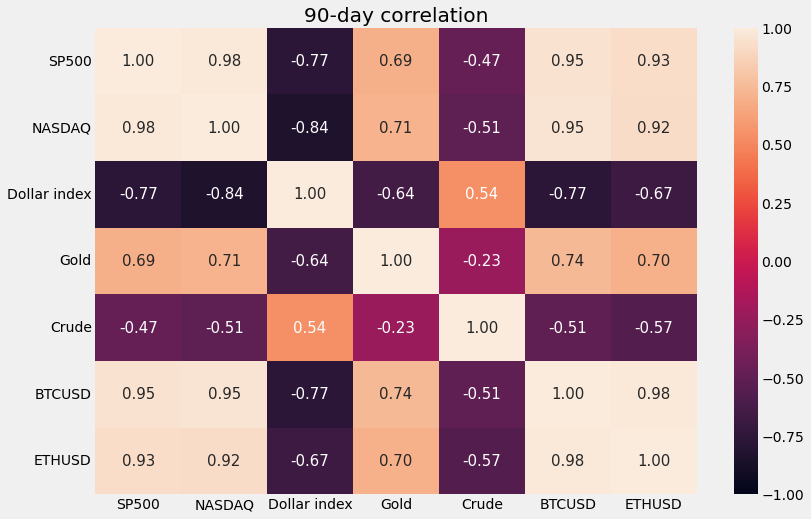

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt=".2f", ax=ax, annot_kws={"size": 15})
_ = ax.set(title=f"{period}-day correlation", xlabel="", ylabel="")

## 滚动相关系数

BTC与标普500，纳斯达克，黄金，美元指数的相关系数。

In [12]:
# 滚动窗口天数
window = 90

idx = pd.IndexSlice
rolling_corr = (
    prices.rolling(window).corr()
          .loc[idx[:, "BTCUSD"], ["SP500", "NASDAQ", "Dollar index", "Gold"]]
          .reset_index(level="Symbols", drop=True)
          .dropna()
          .loc["2021":]
)

rolling_corr.tail()

Symbols,SP500,NASDAQ,Dollar index,Gold
Date,,,,
2022-06-16,0.945270,0.956825,-0.758985,0.639032
2022-06-17,0.948487,0.957257,-0.761525,0.667965
2022-06-21,0.950614,0.956894,-0.762686,0.694949
2022-06-22,0.951942,0.955811,-0.763459,0.718868
2022-06-23,0.952919,0.954408,-0.767378,0.741120


In [13]:
rolling_corr_wide = rolling_corr.reset_index().melt(id_vars="Date", var_name="asset", value_name="corr")
# rolling_corr_wide

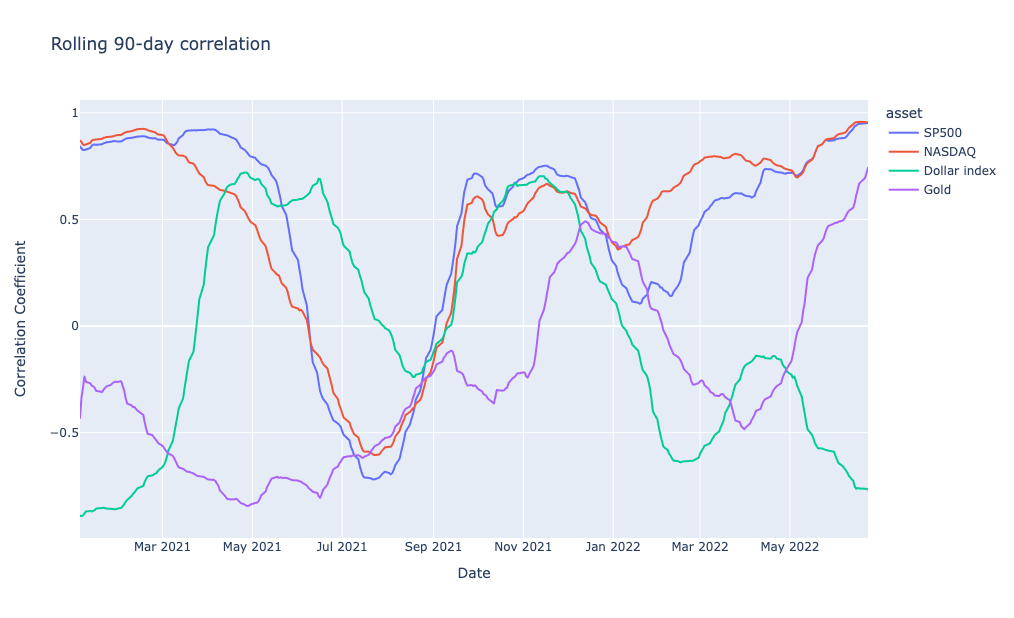

In [14]:
fig = px.line(rolling_corr_wide, x="Date", y="corr", color="asset",
              title=f"Rolling {window}-day correlation",
              width=1000, height=618)
fig.update_layout(yaxis_title="Correlation Coefficient")
fig.show()